In [1]:
# First, the import.
from textblob import TextBlob
from textblob import Word

from textblob.wordnet import VERB

from textblob.classifiers import NaiveBayesClassifier

# For reading input files in CSV format
import csv

# For doing cool regular expressions
import re

# For sorting dictionaries
import operator


# For plotting results
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

In [2]:
# pip install -U textblob
# python -m textblob.download_corpora

In [3]:
# Intialize an empty list to hold all of the tweets
tweets = []

In [4]:
# A helper function that removes all the non ASCII characters
# from the given string. Retuns a string with only ASCII characters.
def strip_non_ascii(string):
    ''' Returns the string without non ASCII characters'''
    stripped = (c for c in string if 0 < ord(c) < 127)
    return ''.join(stripped)

In [5]:
# LOAD AND CLEAN DATA

# Load in the input file and process each row at a time.
# We assume that the file has three columns:

# 0. The tweet text.
# 1. The tweet ID.
# 2. The tweet publish date

In [6]:
# We create a data structure for each tweet:
#
# id:       The ID of the tweet
# pubdate:  The publication date of the tweet
# orig:     The original, unpreprocessed string of characters
# clean:    The preprocessed string of characters
# TextBlob: The TextBlob object, created from the 'clean' string

In [5]:
with open(r'E:\MYLEARN\2-ANALYTICS-DataScience\datasets\newtwitter.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader) 
    # reader.next()
    for row in reader:

        tweet= dict()
        tweet['orig'] = row[0]
        tweet['id'] = int(row[1])
        tweet['pubdate'] = int(row[2])

        # Ignore retweets
        if re.match(r'^RT.*', tweet['orig']):
            continue

        tweet['clean'] = tweet['orig']

        # Remove all non-ascii characters
        tweet['clean'] = strip_non_ascii(tweet['clean'])

        # Normalize case
        tweet['clean'] = tweet['clean'].lower()

        # Remove URLS. 
        tweet['clean'] = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', tweet['clean'])

        # Fix classic tweet lingo
        tweet['clean'] = re.sub(r'\bthats\b', 'that is', tweet['clean'])
        tweet['clean'] = re.sub(r'\bive\b', 'i have', tweet['clean'])
        tweet['clean'] = re.sub(r'\bim\b', 'i am', tweet['clean'])
        tweet['clean'] = re.sub(r'\bya\b', 'yeah', tweet['clean'])
        tweet['clean'] = re.sub(r'\bcant\b', 'can not', tweet['clean'])
        tweet['clean'] = re.sub(r'\bwont\b', 'will not', tweet['clean'])
        tweet['clean'] = re.sub(r'\bid\b', 'i would', tweet['clean'])
        tweet['clean'] = re.sub(r'wtf', 'what the fuck', tweet['clean'])
        tweet['clean'] = re.sub(r'\bwth\b', 'what the hell', tweet['clean'])
        tweet['clean'] = re.sub(r'\br\b', 'are', tweet['clean'])
        tweet['clean'] = re.sub(r'\bu\b', 'you', tweet['clean'])
        tweet['clean'] = re.sub(r'\bk\b', 'OK', tweet['clean'])
        tweet['clean'] = re.sub(r'\bsux\b', 'sucks', tweet['clean'])
        tweet['clean'] = re.sub(r'\bno+\b', 'no', tweet['clean'])
        tweet['clean'] = re.sub(r'\bcoo+\b', 'cool', tweet['clean'])

        # Emoticons?
        # NOTE: Turns out that TextBlob already handles emoticons well, so the
        # following is not actually needed.
        # See http://www.datagenetics.com/blog/october52012/index.html
        # tweet['clean'] = re.sub(r'\b:\)\b', 'good', tweet['clean'])
        # tweet['clean'] = re.sub(r'\b:D\b', 'good', tweet['clean'])
        # tweet['clean'] = re.sub(r'\b:\(\b', 'sad', tweet['clean'])
        # tweet['clean'] = re.sub(r'\b:-\)\b', 'good', tweet['clean'])
        # tweet['clean'] = re.sub(r'\b=\)\b', 'good', tweet['clean'])
        # tweet['clean'] = re.sub(r'\b\(:\b', 'good', tweet['clean'])
        # tweet['clean'] = re.sub(r'\b:\\\b', 'annoyed', tweet['clean'])

        # Create textblob object
        tweet['TextBlob'] = TextBlob(tweet['clean'])

        # Correct spelling (WARNING: SLOW)
        #tweet['TextBlob'] = tweet['TextBlob'].correct()

        tweets.append(tweet)

In [6]:
len(tweets)

6997

In [7]:
tweets[:10]

[{'orig': '10 Things Missing In The New Twitter Interface http://bit.ly/bLZXI3 #NewTwitter',
  'id': 2602860537,
  'pubdate': 18536,
  'clean': '10 things missing in the new twitter interface  #newtwitter',
  'TextBlob': TextBlob("10 things missing in the new twitter interface  #newtwitter")},
 {'orig': 'Aaaaaaaand I have the new twitter! Yay! I should have checked sooner, but I have been busy. I like it! #NewTwitter',
  'id': 2602738438,
  'pubdate': 18535,
  'clean': 'aaaaaaaand i have the new twitter! yay! i should have checked sooner, but i have been busy. i like it! #newtwitter',
  'TextBlob': TextBlob("aaaaaaaand i have the new twitter! yay! i should have checked sooner, but i have been busy. i like it! #newtwitter")},
 {'orig': 'can I please have the new twitter? #twitter #newtwitter',
  'id': 2602684185,
  'pubdate': 18535,
  'clean': 'can i please have the new twitter? #twitter #newtwitter',
  'TextBlob': TextBlob("can i please have the new twitter? #twitter #newtwitter")},
 {

In [10]:
# DEVELOP MODELS

for tweet in tweets:
    tweet['polarity']     = float(tweet['TextBlob'].sentiment.polarity)
    tweet['subjectivity'] = float(tweet['TextBlob'].sentiment.subjectivity)

    if tweet['polarity'] >= 0.1:
        tweet['sentiment'] = 'positive'
    elif tweet['polarity'] <= -0.1:
        tweet['sentiment'] = 'negative'
    else:
        tweet['sentiment'] = 'neutral'

In [11]:
tweets_sorted = sorted(tweets, key=lambda k: k['polarity'])

In [12]:
# EVALUATE RESULTS

# First, print out a few example tweets from each sentiment category.

print ("\n\nTOP NEGATIVE TWEETS")
negative_tweets = [d for d in tweets_sorted if d['sentiment'] == 'negative']
for tweet in negative_tweets[0:100]:
    print ("id=%d, polarity=%.2f, clean=%s" % (tweet['id'], tweet['polarity'], tweet['clean']))

print ("\n\nTOP POSITIVE TWEETS")
positive_tweets = [d for d in tweets_sorted if d['sentiment'] == 'positive']
for tweet in positive_tweets[-100:]:
    print ("id=%d, polarity=%.2f, clean=%s" % (tweet['id'], tweet['polarity'], tweet['clean']))

print ("\n\nTOP NEUTRAL TWEETS")
neutral_tweets = [d for d in tweets_sorted if d['sentiment'] == 'neutral']
for tweet in neutral_tweets[0:500]:
    print ("id=%d, polarity=%.2f, clean=%s" % (tweet['id'], tweet['polarity'], tweet['clean']))



TOP NEGATIVE TWEETS
id=2698404191, polarity=-1.00, clean=grrr #newtwitter stop suggesting me to follow @justinbieber ,i'm never going to!!!!!!!!!!
id=2697847427, polarity=-1.00, clean=i hate the #newtwitter!
id=2697703319, polarity=-1.00, clean=and what is this #newtwitter bullshit?! i hate it!
id=2697201327, polarity=-1.00, clean=oh. #newtwitter is still here. i thought it was just a horrible dream.
id=2697066196, polarity=-1.00, clean=copy that - its way buggy! -- rt @chqwn #newtwitter has the worst messages system. oh and it's laggy. #whineykids
id=2697044605, polarity=-1.00, clean=#newtwitter has the worst messages system. oh and it's laggy. #whineykids
id=2707825483, polarity=-1.00, clean=i hate #newtwitter!! rt if you too
id=2707753987, polarity=-1.00, clean=why doesn't #newtwitter show the convo? its so annoying! i can't see what people replied to!
id=2707537275, polarity=-1.00, clean=i try and try and try - bloody nothing! #newtwitter
id=2707474348, polarity=-1.00, clean=@mar

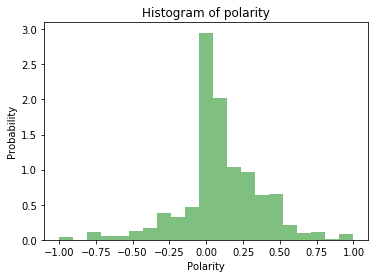

In [13]:
# Next, create some plots

# A histogram of the scores.
x = [d['polarity'] for d in tweets_sorted]
num_bins = 21
n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='green', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Probability')
plt.title(r'Histogram of polarity')
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()